# Importing libraries and loading data

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import preprocessing
from datetime import datetime as dt
from tensorflow.python import keras 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import IFrame
import ipywidgets as widgets
from sklearn.preprocessing import MinMaxScaler
from utils import *
import datetime

# Loading model

(1451, 47)
We have removed 113 outliers tuples (which is 7.787732598208132 % of total).
(1338, 28)
(1338, 1)


/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 27)                756       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                392       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 1,163
Trainable params: 1,163
Non-trainable params: 0
_________________________________________________________________
1338/1338 [==============================] - 0s 205us/sample - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1727
[[0.2811199 ]
 [0.36230287]
 [0.29218358]
 ...
 [0.16268475]
 [0.3873538 ]
 [0.2402226 ]]
MSE: 58.905

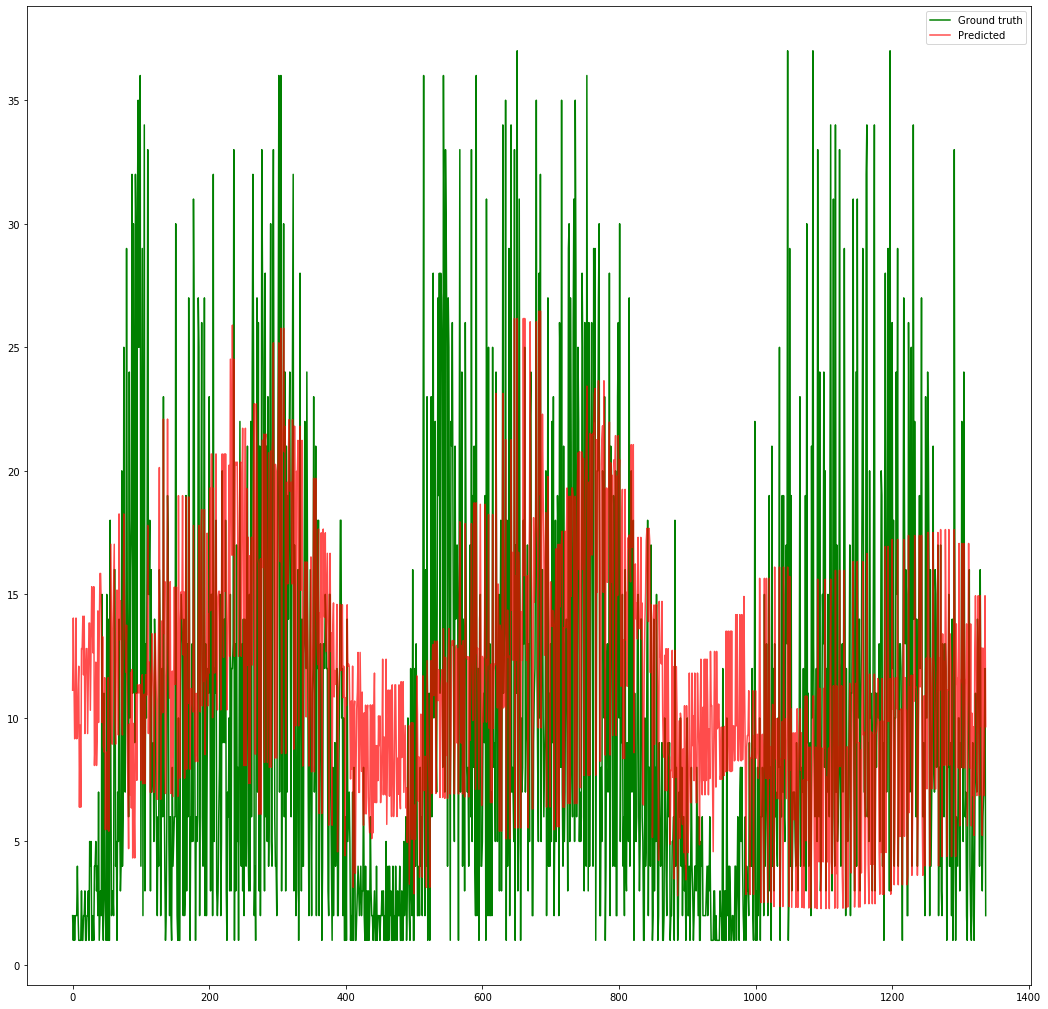

In [2]:
update_one_hot_data('./data/combined_data_22-jun.tsv','./data/combined_data_22-jun_one_hot_data.tsv')
df_new_data = pd.read_csv('./data/combined_data_22-jun_one_hot_data.tsv',
                 sep='\t',
                 header=0)
start_size=df_new_data.shape[0]
print(df_new_data.shape)
df_new_data = remove_outlier(df_new_data, "bike_count")
print("We have removed "+str(start_size-df_new_data.shape[0])+" outliers tuples (which is "+str((start_size-df_new_data.shape[0])/start_size*100)+" % of total).")
df_new_data=remove_features(df_new_data)    
df_new_data.set_index('timestamp_from', inplace=True)
df_new_data = df_new_data.sort_values(by=['timestamp_from'])
print(df_new_data.shape)


#set bike_count as Y
df_y = df_new_data.bike_count
df_x = df_new_data.drop(columns="bike_count")


#Normalization
x = df_x.values
y = df_y.values.reshape(-1, 1)
print(y.shape)
x_scaler = preprocessing.MinMaxScaler()
x_normalized = x_scaler.fit_transform(x)

y_scaler = preprocessing.MinMaxScaler()
y_normalized = y_scaler.fit_transform(y)

x_in = pd.DataFrame(x_normalized)
y_in = pd.DataFrame(y_normalized)




new_model = keras.models.load_model('./model/model-23-jun.bin')
new_model.summary()
evaluate_model_and_show_graph(x_in,y_in,new_model,y_scaler)


# Show bike poles map

In [3]:
if not os.path.isfile('./map/bike_Brussels-points-map.html'):
    from map.generate_map import GENERATE_MAP_MAIN_FUNCTION
    GENERATE_MAP_MAIN_FUNCTION()
IFrame(src='./map/bike_Brussels-points-map.html',width=900,height=600)


# Select calendar

In [4]:
print("Select a start and end date")
start_date=datetime.datetime.now()
end_date=datetime.datetime.now()
@widgets.interact(start=widgets.DatePicker(),value='2019-06-19')
def foo(start=datetime.datetime.now()):
    global start_date
    start_date=start
    return str(start)
@widgets.interact(end=widgets.DatePicker())
def foo2(end=datetime.datetime.now()):
    global end_date
    end_date=end
    return str(end)

Select a start and end date


interactive(children=(DatePicker(value=None, description='start'), Output()), _dom_classes=('widget-interact',…

interactive(children=(DatePicker(value=None, description='end'), Output()), _dom_classes=('widget-interact',))

# Gather information

In [5]:
if start_date ==None or end_date==None:
    print("You need to set a start and end date")
else:
    if start_date==end_date:
        print("The dates must be different.")
    else:
        obtain_next_dates_data(start_date,end_date)


https://api.aerisapi.com/forecasts/50.82448,4.393893?from=1561586400&to=1561672800&filter=1hr&client_id=6mzRG6y1n6A6Dy3lQXRPT&client_secret=UP3GNV20hMBGP5CLnzyO8SSt51HpX0qSKeNEuEBx
https://api.aerisapi.com/forecasts/50.84337,4.378814?from=1561586400&to=1561672800&filter=1hr&client_id=6mzRG6y1n6A6Dy3lQXRPT&client_secret=UP3GNV20hMBGP5CLnzyO8SSt51HpX0qSKeNEuEBx
https://api.aerisapi.com/forecasts/50.84048,4.34001?from=1561586400&to=1561672800&filter=1hr&client_id=6mzRG6y1n6A6Dy3lQXRPT&client_secret=UP3GNV20hMBGP5CLnzyO8SSt51HpX0qSKeNEuEBx
https://api.aerisapi.com/forecasts/50.88185,4.373961?from=1561586400&to=1561672800&filter=1hr&client_id=6mzRG6y1n6A6Dy3lQXRPT&client_secret=UP3GNV20hMBGP5CLnzyO8SSt51HpX0qSKeNEuEBx
https://api.aerisapi.com/forecasts/50.8392,4.400259?from=1561586400&to=1561672800&filter=1hr&client_id=6mzRG6y1n6A6Dy3lQXRPT&client_secret=UP3GNV20hMBGP5CLnzyO8SSt51HpX0qSKeNEuEBx
https://api.aerisapi.com/forecasts/50.85363,4.34124?from=1561586400&to=1561672800&filter=1hr&clie

# Predict

In [6]:
update_one_hot_data('./data/next_dates_data.tsv','./data/next_dates_data_one_hot_data.tsv')
df_next_days_data = pd.read_csv('./data/next_dates_data_one_hot_data.tsv',
                 sep='\t',
                 header=0)
start_size=df_next_days_data.shape
print(start_size)
df_next_days_data=remove_features(df_next_days_data)
df_next_days_data.set_index('timestamp_from', inplace=True)
df_next_days_data = df_next_days_data.sort_values(by=['timestamp_from'])
print(df_next_days_data.shape)

x_scaler = MinMaxScaler()

x_data=df_next_days_data.drop(columns="bike_count")
x_normalized = x_scaler.fit_transform(x_data)
x_in = pd.DataFrame(x_normalized)
bike_prediction = new_model.predict(x_in)



y_normalized = y_scaler.fit_transform(y)
predicted_values=y_scaler.inverse_transform(bike_prediction)


(225, 47)
(225, 28)


/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Show forecasting on static map

In [7]:
from map.generate_map import GENERATE_HEAT_MAP
GENERATE_HEAT_MAP(x_data,predicted_values)
IFrame(src='./map/forecasting_ap.html',width=900,height=600)

# Show forecasting on dynamic map

In [ ]:
import folium
import folium.plugins as plugins
import numpy as np
from datetime import datetime as dt
def convert_to_proper_list(lat_list,long_list):
    return_list=[]
    for i in range(0,len(lat_list)):
        return_list.append([lat_list[i],long_list[i]])
    return return_list    
def convert_row_to_multiple_points(data):
    import random 
    rand_limits=0.01
    return_list=[]
    for row in data:
        temp_row=[]
        for tuple_r in row:            
            for i in range(0,tuple_r[2]):
                #print(random.uniform(-rand_limits,rand_limits))
                temp_row.append([tuple_r[0]+random.uniform(-rand_limits,rand_limits),tuple_r[1]+random.uniform(-rand_limits,rand_limits),1])            
        return_list.append(temp_row)
    return return_list            
def SHOW_DYNAMIC_MAP(x_data,predicted_num_bikes):
    import random    
    import statistics as st
    data_information=[]
    latitudes_list=[]
    longitudes_list=[]
    timestamp_list=[]
    rand_limits=0    
    for row in x_data.index:
        timestamp_list.append(row)
    for row in x_data.latitude:
        latitudes_list.append(row+random.uniform(-rand_limits,rand_limits))
    for row in x_data.longitude:
        longitudes_list.append(row+random.uniform(-rand_limits,rand_limits))  
    for i in range(0,len(latitudes_list)):
        data_information.append([latitudes_list[i],longitudes_list[i],float(predicted_num_bikes[i])])             
    data=[]   
    for i in range(0,int(len(timestamp_list)/9)):
        data.append(convert_to_proper_list(latitudes_list[i*9:(i*9)+9],longitudes_list[i*9:(i*9)+9]))              
    weight = 1  # default value
    i=0
    
    for time_entry in data:
        for row in time_entry:
            row.append(int(predicted_num_bikes[i]))
            i+=1
    
    from datetime import datetime, timedelta   
    time_index = [
        (dt.fromtimestamp(k)).strftime('%Y-%m-%d-%H:%M:%S') for k in timestamp_list
    ]       
    time_index=list(np.unique(np.array(time_index)))    
    
    print(predicted_num_bikes)
    input()
    #print(time_index)
    print(data[23])
    print(data[24])
    data=convert_row_to_multiple_points(data)
    #print(data[0])
    #input()
    
    m = folium.Map([st.mean(latitudes_list), st.mean(longitudes_list)], tiles='OpenStreetMap', zoom_start=11.5)
    hm = plugins.HeatMapWithTime(
        data,
        index=time_index,
        auto_play=True,
        max_opacity=0.3
    )

    hm.add_to(m)

    m.save('./map/dynamic_forecasting_ap.html')
SHOW_DYNAMIC_MAP(x_data,predicted_values)
IFrame(src='./map/dynamic_forecasting_ap.html',width=900,height=600)

[[10.792635 ]
 [11.837954 ]
 [ 8.832033 ]
 [ 8.910251 ]
 [ 8.582936 ]
 [11.8531475]
 [13.847771 ]
 [11.344029 ]
 [ 9.355237 ]
 [11.545395 ]
 [10.597128 ]
 [ 8.531571 ]
 [ 9.15914  ]
 [ 8.531926 ]
 [12.077641 ]
 [ 9.145457 ]
 [12.062446 ]
 [13.633949 ]
 [12.188653 ]
 [ 8.785229 ]
 [ 9.346973 ]
 [ 8.545508 ]
 [12.168783 ]
 [10.816351 ]
 [13.582006 ]
 [ 8.236583 ]
 [11.606118 ]
 [ 8.0123415]
 [10.725684 ]
 [12.195554 ]
 [ 9.206421 ]
 [14.007321 ]
 [11.344028 ]
 [ 9.368262 ]
 [ 7.9838347]
 [11.836224 ]
 [11.822512 ]
 [11.29398  ]
 [ 9.730301 ]
 [10.434799 ]
 [ 7.470266 ]
 [11.842382 ]
 [13.448054 ]
 [ 9.362224 ]
 [ 8.147657 ]
 [13.426136 ]
 [11.148632 ]
 [ 6.6401243]
 [ 8.2027025]
 [10.172113 ]
 [11.703371 ]
 [ 9.526174 ]
 [ 8.590781 ]
 [11.696567 ]
 [12.274172 ]
 [12.29493  ]
 [ 8.045386 ]
 [ 8.605939 ]
 [ 5.6755214]
 [14.665789 ]
 [ 9.424073 ]
 [ 9.115304 ]
 [11.245453 ]
 [ 9.159508 ]
 [ 8.97678  ]
 [11.138283 ]
 [11.95133  ]
 [16.035288 ]
 [ 8.040463 ]
 [ 9.390675 ]
 [11.952894 ]
 [ 5.6